# Representation of s-process abundances for comparison to data from bulk meteorites
## Companion Notebook
---
This notebook accompanies the paper *Representation of s-process abundances for comparison to data from bulk meteorites* by Lugaro et al. published in the *European Physical Journal A* 2023. Below is code to generate comparable figures to those within the paper and to generate the dataset comparing the mixing lines generated using the exponential and linear equations, as well as the linear equations from Dauphas et al. [2].

The code in this notebook uses the [isopy](https://isopy.readthedocs.io/en/latest/) package which requires python 3.9 or above to run. The package can be installed using:
```bash
pip install isopy==<version>
```
The isopy package is under active development and newer version might include breaking changes. To ensure the code runs smoothly it is therefore recomended to use the version indicated next to the import statement in the main code block.

### References
[1] Lugaro et al., Submitted 2023, EPJA  
[2] [Dauphas et al., 2004, EPSL, 226, 465-475](https://doi.org/10.1016/j.epsl.2004.07.026)  
[3] [Lodders et al., 2009, In Solar System, 4B, 4.4](https://doi.org/10.1007/978-3-540-88055-4_34)  
[4] [Anders & Grevasse, 1989, GCA, 53, 197-214](https://doi.org/10.1016/0016-7037(89)90286-X)  
[5] [FRUITY Database ](http://fruity.oa-teramo.inaf.it/modelli.pl)  
[6] [Stephan et al., 2019, ApJ, 877:101](https://doi.org/10.3847/1538-4357/ab1c60)  
[7] [Brennecka et al. (2020), Science, 370](https://doi.org/10.1126/science.aaz8482)  
[8] [Burkhardt et al. (2021), Science Advances, 7](https://doi.org/10.1126/sciadv.abj7601)  
[9] [Budde et al. (2019), Nature Astronomy, 3](https://doi.org/10.1038/s41550-019-0779-y)  

## Main Code
---
This cell must be executed before any of the examples

In [1]:
import isopy # version 0.7.7
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import warnings, itertools, io, os, string
import openpyxl, PIL

isopy.core.ARRAY_REPR.pop('nrows', 0)
mpl.rcParams.update({'font.size': 15, 'axes.labelsize': 20})

EPS = r'\epsilon'
EPS_star = r'\epsilon^{\ast}'
EPS_lin = r'\epsilon_{\rm{lin}}'
lin = r'_{\rm{lin}}'

#######################
### Model Functions ###
#######################

def load_models(filename, mass_fraction, normalise_to_si):
    """
    Load the model abundances from *filename* and return a dictionary containing the
    model parameters and abundance. Any column which is not an isotope is assumed 
    to be a model parameter.
    
    Form compatability with the code the name of the model should be given
    the header 'name'.
    
    If *mass_fraction* is True then the model abundances are divided by the isotope mass
    to convert the data from mass fractions.
    
    If *normalise_to_si* is True then the abundances are renormalised so that the sum of all Si 
    isotopes is equal to 10^6.
    """
    model_abundances = isopy.read_csv(filename, keys_in_first = 'r')

    models = {}

    # Everything that is not an isotope is assumed to be a model parameter
    for key in tuple(model_abundances.keys()):
        if isopy.keystring(key).flavour != 'isotope':
            values = model_abundances.pop(key)
            try:
                # If possible make it an array of floats
                models[key] = np.array(values, dtype=np.float64)
            except ValueError:
                models[key] = np.array(values)
    
    models['abundance'] = isopy.asrefval(model_abundances, ratio_function=np.divide)
    
    if mass_fraction:
        models['abundance'] = isopy.divide(models['abundance'], mass, 
                                           keys=models['abundance'].keys)
    
    if normalise_to_si:
        sum_of_isotopes = isopy.sum(models['abundance'], element_symbol_eq='si', axis=1)
        models['abundance'] = models['abundance'] * (1E6 / sum_of_isotopes)
    
    return models
    

def select_models(models, **parameter_comparison):
    """
    Select a subsection of models from *models* by filtering on the parameters.
    
    To filter a paramteter the argument name should be the name parameter followed by 
    an underscore and then the comparison type, the value is the one to be used for the 
    comparison e.g.
    
    ``select_models(all_models, z_ge = 0.014)``
    
    to select only the models with a solar or higher metalicity. 
    
    The avaliable comparisons are: eq (==), neq (!=), in (in), nin (not in),
    lt (<), gt (>), le (>=), ge (>=)
    """
    indexes = [i for i in range(models['abundance'].size)]
    
    for p_c, value in parameter_comparison.items():
        p,c = p_c.rsplit('_', 1)
        parameter = models[p]
        
        if c == 'eq':
            indexes = [i for i in indexes if parameter[i] == value]
        elif c == 'neq':
            indexes = [i for i in indexes if parameter[i] != value]
        elif c == 'le':
            indexes = [i for i in indexes if parameter[i] <= value]
        elif c == 'ge':
            indexes = [i for i in indexes if parameter[i] >= value]
        elif c == 'lt':
            indexes = [i for i in indexes if parameter[i] < value]
        elif c == 'ge':
            indexes = [i for i in indexes if parameter[i] > value]
        elif c == 'in':
            indexes = [i for i in indexes if parameter[i] in value]
        elif c == 'nin':
            indexes = [i for i in indexes if parameter[i] not in value]
    
    new_models = {}
    for key in models.keys():
        new_models[key] = models[key][indexes].copy()

    return new_models

def recalculate_solar(solar, normrat, value):
    """
    Recalculates the *solar* value such that *normrat* is equal to *value*.
    
    Only returns the isotopes of the element in *normrat*.
    """
    normrat = isopy.askeystring(normrat, flavour='ratio[isotope,isotope]')
    element = normrat.numerator.element_symbol
    
    new = solar.to_array(element_symbol=element)
    new = isopy.tb.internal_normalisation(new, normrat, isotope_fractions={normrat: value})
    new = isopy.cstack(new, {normrat: value})
    new = new.deratio(solar[normrat.denominator], sort_keys=False)
    
    return new.to_refval(ratio_function='divide')

###############################
### Normalisation Functions ###
###############################

def simple_normalisation(models, normiso, solar, *, largest_offset=None):
    """
    Calculates the epsilon values, normalised to *normiso*, for all *models* relative 
    to the *solar* value.
    
    If *largest_offset* is given then the calculation is made using a synthetic sample created by 
    adding a small amount of the model abundance to the the solar abundances so that the largest 
    offset calculated for each model is always equal to the given value. If *largest_offset* 
    is not given the calculation is made using the raw model abundances.
    """
    normiso = isopy.askeystring(normiso, flavour='isotope')
    element = normiso.element_symbol
    j = normiso
    
    std = solar.to_array(element_symbol=element)
    s = models['abundance'].to_array(std.keys)
    
    x = 1E-4
    R_std = std / std[j]
    
    for i in range(5):
        if largest_offset:
            smp = std + s * x
        else:
            smp = s
            
        r_smp = smp / smp[j]
        
        eps = ((r_smp / R_std) - 1) * 1E4
    
        maxval = np.nanmax(np.abs(eps), axis=1)
        if largest_offset is None:
            break
        elif np.allclose(maxval, largest_offset):
            break
        else:
            x = x / (maxval / largest_offset)
    else:
        print(x)
        warnings.warn('Unable to create anomaly of the desired magnitude for one or more models')        
    
    return eps.to_array(key_neq=[j])

def internal_normalisation(models, normrat, solar, *, linear=True, largest_offset=None):
    """
    Calculates the internaly normalised epsilon values for all *models* for the ratio *normrat* relative 
    to the *solar* value using the equations in Lugaro et al. [1].
    
    When *linear* is ``True`` the calculation corresponds to equation 7, when ``False`` the calculation 
    corresponds to equation 6.
    
    If *largest_offset* is given then the calculation is made using a synthetic sample created by 
    adding a small amount of the model abundance to the the solar abundances so that the largest 
    offset calculated for each model is always equal to the given value. If *largest_offset* 
    is not given the calculation is made using the raw model abundances.
    """
    normrat = isopy.askeystring(normrat, flavour='ratio[isotope,isotope]')
    element = normrat.numerator.element_symbol
    k = normrat.numerator
    j = normrat.denominator
    
    std = solar.to_array(element_symbol=element)
    s = models['abundance'].to_array(std.keys)
    m = mass.to_array(std.keys)
    
    Q = (np.log(m) - np.log(m[j])) / (np.log(m[k])-np.log(m[j]))
    R_std = std / std[j]
    
    if linear:
        # This corresponds to equation 7
        r_smp = s / s[j]
        eps = ((r_smp / R_std - 1) - Q * (r_smp[k]/R_std[k] -1)) * 1E4
        if largest_offset:
            eps = (eps / np.nanmax(np.abs(eps), axis=1)) * largest_offset
    else:
        # This corresponds to equation 6
        x = 1E-4
        for i in range(5):
            if largest_offset:
                smp = std + s * x
            else:
                smp = s

            r_smp = smp / smp[j]
            eps = ((r_smp / R_std) * np.power((r_smp[k]/R_std[k]), -Q) - 1) * 1E4

            maxval = np.nanmax(np.abs(eps), axis=1)
            if largest_offset is None:
                break
            elif np.allclose(maxval, largest_offset):
                break
            else:
                x = x / (maxval / largest_offset)
        else:
            print(x)
            warnings.warn('Unable to create anomaly of the desired magnitude for one or more models')       
    
    return eps.to_array(key_neq=[k,j])

def dauphas_normalisation(models, normrat, solar, largest_offset=None):
    """
    Calculates the internaly normalised epsilon values for all *models* for the ratio *normrat* relative 
    to the *solar* value using the equations in Dauphas et al. [2].
    
    These are the same as the linearised internal normalisation above with a further similification of Q.
    
    If *largest_offset* is not None then the result is normalised to that the absolute value of the 
    largest offset is equal to *largest_offset*.
    """
    normrat = isopy.askeystring(normrat, flavour='ratio[isotope,isotope]')
    element = normrat.numerator.element_symbol
    
    initial = solar.to_array(element_symbol=element)
    yields = models['abundance'].to_array(initial.keys)
    m = mass.to_array(initial.keys)
    
    p = (yields / yields[normrat.denominator])  / (initial / initial[normrat.denominator]) - 1
    u = (m - m[normrat.denominator]) / (m[normrat.numerator] - m[normrat.denominator])
    
    result = p - p[normrat.numerator] * u
    result = result.to_array(key_neq=[normrat.numerator, normrat.denominator])
    if largest_offset:
        result = (result / np.nanmax(np.abs(result), axis=1)) * largest_offset
    
    return result

##########################
### Plotting Functions ###
##########################

def create_subplots(nsubplots, grid, row_height=5, column_width=5, legend = None, legend_ratio=1):
    """
    Create *nsubplots* number of subplots in a (nrows, ncolumns) *grid*. nrows or ncolumns can be -1 to
    create as many rows/columns as necessary to accommodate the number of subplots. Each subplot will be
    named "ax<nsubplot>" from left to right, top to bottom.
    
    *row_height* and *column_width* is the size of each subplot in the grid.
    
    If *legend* is True a subplot named "legend" is included spanning every column
    at the bottom of the subplot. *legend_ratio* is the height of the this subplot 
    relative to the other subplots.
    """
    if legend is True: legend = 's'
    axes = isopy.tb.create_subplots(plt, nsubplots, grid, 
                                    row_height=row_height, column_width=column_width,
                                    legend=legend, legend_ratio=legend_ratio)
    
    for i, (name, ax) in enumerate(axes.items()):
        if name != 'legend':
            isopy.tb.update_axes(ax, xlim = (-1, 1), ylim = (-1, 1), 
                                 xticks = [-1, -0.5, 0, 0.5, 1], yticks = [-1, -0.5, 0, 0.5, 1])
            ax.axhline(0, color='black', linestyle='-', linewidth = 0.5)
            ax.axvline(0, color='black', linestyle='-', linewidth = 0.5)
            ax.annotate(f'{string.ascii_lowercase[i]})', (-0.25, 1), xycoords='axes fraction')
    return axes

def create_legend(axes, model_names, *result_names, ncol = 3, simplified = False):
    """
    Creates a legend in *axes*. 
    
    If *simplified* is False a legend entry will be created for each item in the plot.
    
    If *simplified* is True then the *result_names* will be plotted as a blackline with the corresponding
    linestyle and *model_names* will be plotted as a solid line with the corresponding colour.
    
    *ncols* is the number of columns used for the legend.
    """
    if isinstance(axes, dict):
        axes = axes['legend']
    linestyles = ['-', '--', '-.', ':']
    colors = isopy.tb.Colors()
    legend_items = {}
    
    if simplified:
        for i, result_name in enumerate(result_names):
            legend_items[result_name] = dict(linestyle=linestyles[i], color='black')

        for i, model_name in enumerate(model_names):
            legend_items[model_name] = dict(linestyle='-', color=colors[i])
    else:
        for j, model_name in enumerate(model_names):
            for i, result_name in enumerate(result_names):
                legend_items[f'{result_name} {model_name}'] = dict(linestyle=linestyles[i], color=colors[j])
    
    isopy.tb.create_legend(axes, newlines=legend_items, hide_axis=True, loc=9, ncol=ncol)
    
def plot_arrow(axes, x, y, position=0.9, color=None):
    """
    Plots an arrow on an existing mixing line in the direction of the (*x*, *y*) end-member.
    
    The arrow will be plotted at the relative *position* along the line
    
    *color* is the colour of the arrow. Can be an integer which will select the corresponding default colour.
    """
    if type(color) is int:
        color = isopy.tb.Colors[color]
                                     
    slope = y / x
    
    if np.abs(slope) > 1:
        y_arrow = np.array([position, position+0.01]) * (-1 if y < 0 else 1)  
        x_arrow = 1 / slope * y_arrow
    else:
        x_arrow = np.array([position, position+0.01]) * (-1 if x < 0 else 1) 
        y_arrow = slope * x_arrow
    
    axes.arrow(x_arrow[0], y_arrow[1], x_arrow[1]-x_arrow[0], y_arrow[1]-y_arrow[0], 
             linewidth=0, length_includes_head=True, head_width=0.08, 
             zorder=3, facecolor=color)

def plot_slope(axes, xiso, yiso, *results, title=None, xy_suffix = '', epsilon = EPS, arrow=False, arrow_position=0.9):
    """
    Plots the slope of *xiso* and *yiso* for each model in each result in *results*. The colour used
    for each model is the same for each result but the line style varies for each result.
    
    The x and y axis label will be set to epsilon xiso/yiso and if given *xy_suffix* will be
    appended to each label. The *epsilon* argument can be used to set the type of epsilon used.
    Options are 'EPS' for regular epsilon, 'EPS_star' or 'EPS_lin'.
    
    *title* will add text to the top of the figure.
    
    If *arrow* is True an arrow will be shown on each mixing lines indicating the position of the end member.
    The location of the arrow is given by *arrow_position*, which can be a nested list for each result/model 
    e.g. [[result1_model1, result1_model2], [result2_model1, result2_model2]].
    """   
    xiso = isopy.askeystring(xiso)
    yiso = isopy.askeystring(yiso)
    
    if type(arrow_position) is not list:
        arrow_position = [[arrow_position] * r.size for r in results]
        
    if type(epsilon) is not tuple:
        epsilon = (epsilon, )
    xlabel = fr'${"$, $".join(epsilon)}\,{xiso.str("math")}${xy_suffix}'
    ylabel = fr'${"$, $".join(epsilon)}\,{yiso.str("math")}${xy_suffix}'
    
    isopy.tb.update_axes(axes, xlabel = xlabel, ylabel = ylabel, title=title)
                                     
    linestyles = ['-', '--', '-.', ':']
    colors = isopy.tb.Colors()
                                     
    for i, result in enumerate(results):            
        for j in range(result.size):
            x = result[j][xiso]
            y = result[j][yiso]
            slope = y / x
            
            axes.axline((0,0), slope = slope, color = colors[j], linestyle=linestyles[i])
            if arrow:
                position = arrow_position[i][j] if type(arrow_position) is list else arrow_position
                plot_arrow(axes, x, y, position, colors[j])
            
def plot_all(model_names, simplified_legend = False, arrow=False, **name_result):
    """
    Creates figure containing regression lines fore every possible combindation of isotopes in the results.
    
    Results should be given as keyword arguments where the name of keyword will be used in the legend together
    with *model_names*.
    
    If *simplified_legend* is True a simplified legend will be shown. Otherwise the legend will contain every
    line in the plot.
    
    If *arrow* is True an arrow will be shown on each mixing lines indicating the position of the end member.
    """
    linestyles = ['-', '--', '-.', ':']
    colors = isopy.tb.Colors()
    
    names = list(name_result.keys())
    results = list(name_result.values())
    
    xy_isotopes = list(itertools.combinations(results[0].keys(), 2))
    legend_ratio = np.ceil(len(model_names)/2) / 10
    
    axes = create_subplots(len(xy_isotopes), grid=(-1, 3), legend=True, legend_ratio=legend_ratio)
        
    for i, (xiso, yiso) in enumerate(xy_isotopes):
        plot_slope(axes[f'ax{i}'], xiso, yiso, *results, arrow=arrow)
        
    create_legend(axes.legend, model_names, ncol=2, simplified = simplified_legend, *names)

## Load models and solar values
---
This code must be executed before any of the examples

In [2]:
# The solar values from Lodders et al. [3]
solar_L09 = isopy.refval.isotope.initial_solar_system_abundance_L09

# The solar values from Anders & Grevesse [4]
solar_AG89 = isopy.refval.isotope.initial_solar_system_abundance_AG89

# The mass of each isotope
mass = isopy.refval.isotope.mass_AME20

# This only included the models and abundances used to create the Figures
monash_models = load_models('Input/monash.csv', mass_fraction=False, normalise_to_si=False)

# All the FRUITY models [5] as of September 2022
fruity_models = load_models('Input/fruity.csv', mass_fraction=True, normalise_to_si=True)

# The internal normalisation ratios and values from Table 1 in Lugaro et al. [1]
normrat_values = isopy.array('Input/Table1.csv')

# From Stephan et al. [6]
SiC_mo = isopy.array(mo92=-1000, mo94=-964, mo95=-615, mo96=0, mo97=-532, mo98=-256, mo100=-980)
SiC_mo = (SiC_mo/1000) + 1
SiC_mo = SiC_mo * solar_L09

In [3]:
normrat_values.tabulate()

$\cfrac{{}^{57}\mathrm{Fe}}{{}^{54}\mathrm{Fe}}$,$\cfrac{{}^{57}\mathrm{Fe}}{{}^{56}\mathrm{Fe}}$,$\cfrac{{}^{61}\mathrm{Ni}}{{}^{58}\mathrm{Ni}}$,$\cfrac{{}^{62}\mathrm{Ni}}{{}^{58}\mathrm{Ni}}$,$\cfrac{{}^{67}\mathrm{Zn}}{{}^{64}\mathrm{Zn}}$,$\cfrac{{}^{68}\mathrm{Zn}}{{}^{64}\mathrm{Zn}}$,$\cfrac{{}^{86}\mathrm{Sr}}{{}^{88}\mathrm{Sr}}$,$\cfrac{{}^{94}\mathrm{Zr}}{{}^{90}\mathrm{Zr}}$,$\cfrac{{}^{98}\mathrm{Mo}}{{}^{96}\mathrm{Mo}}$,$\cfrac{{}^{99}\mathrm{Ru}}{{}^{101}\mathrm{Ru}}$,$\cfrac{{}^{108}\mathrm{Pd}}{{}^{105}\mathrm{Pd}}$,$\cfrac{{}^{134}\mathrm{Ba}}{{}^{136}\mathrm{Ba}}$,$\cfrac{{}^{134}\mathrm{Ba}}{{}^{138}\mathrm{Ba}}$,$\cfrac{{}^{146}\mathrm{Nd}}{{}^{144}\mathrm{Nd}}$,$\cfrac{{}^{147}\mathrm{Sm}}{{}^{154}\mathrm{Sm}}$,$\cfrac{{}^{147}\mathrm{Sm}}{{}^{152}\mathrm{Sm}}$,$\cfrac{{}^{166}\mathrm{Er}}{{}^{168}\mathrm{Er}}$,$\cfrac{{}^{174}\mathrm{Yb}}{{}^{172}\mathrm{Yb}}$,$\cfrac{{}^{179}\mathrm{Hf}}{{}^{177}\mathrm{Hf}}$,$\cfrac{{}^{186}\mathrm{W}}{{}^{183}\mathrm{W}}$,$\cfrac{{}^{186}\mathrm{W}}{{}^{184}\mathrm{W}}$
0.362549,0.023095,0.016744,0.053389,0.08216,0.385564,0.1194,0.3381,1.453173,0.7450754,1.18899,0.3078,0.03371,0.7219,0.65918,0.56083,1.2414,1.4772,0.7325,1.9859,0.92767


----

# Recreate Figures

The following section recreates figures included in the Lugaro et al. [1]

---
## Figure 1

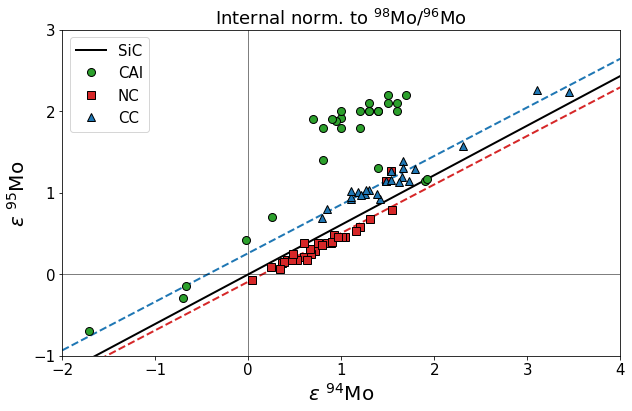

In [4]:
# CAI compilation from Brennecka et al. [7]
CAI = isopy.array('Input/Brennecka20_CAI.csv')

# Bulk meteorite complilation from Burkhardt et al. [8]
NC = isopy.array('Input/Burkhardt21_NC.csv')
CC = isopy.array('Input/Burkhardt21_CC.csv')

green = isopy.tb.Colors[2]
blue = isopy.tb.Colors[0]
red = isopy.tb.Colors[3]

isopy.tb.update_figure(plt, size=(10,6))
isopy.tb.update_axes(plt, xlabel = '$\epsilon\ ^{94}$Mo', 
                     ylabel='$\epsilon\ ^{95}$Mo', 
                     title='Internal norm. to $^{98}$Mo/$^{96}$Mo',
                     xlim=(-2, 4), ylim=(-1, 3), 
                     xticks=[-2, -1, 0, 1, 2, 3, 4],
                     yticks=[-1, 0, 1, 2, 3])

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)


isopy.tb.plot_scatter(plt, CAI['94mo'], CAI['95mo'], color=green, label = 'CAI', markersize=8)
isopy.tb.plot_scatter(plt, NC['94mo'], NC['95mo'], color=red, label = 'NC', markersize=8)
isopy.tb.plot_scatter(plt, CC['94mo'], CC['95mo'], color=blue, label= 'CC', markersize=8)

# From Stephan et al. [6]
isopy.tb.plot_regression(plt, (0.608, 0), color='black', label='SiC', linewidth=2, label_equation=False)
plt.legend()

# From Budde et al. [9]
isopy.tb.plot_regression(plt, (0.596, -0.09), color=red, linewidth=2, linestyle = '--')
isopy.tb.plot_regression(plt, (0.596, 0.26), color=blue, linewidth=2, linestyle = '--')

#plt.savefig('Output/Figure1-MoSummary.pdf')

---
## Figure 2

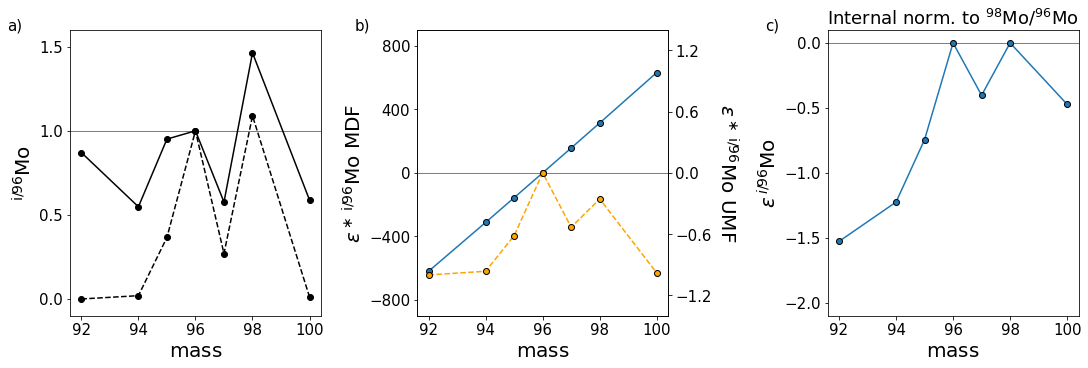

In [5]:
normrat = isopy.keystring('98mo/96mo')
solar_mo = solar_L09.to_array(element_symbol='mo')
mass_mo = mass.to_array(solar_mo.keys).ratio('96mo')

# Create the subplots for our final figure
axes = isopy.tb.create_subplots(plt, [['one', ('twol', 'twor'), 'three']], 
                                figure_width=15, figure_height=5, gridspec_wspace=0.05)

isopy.tb.update_axes(axes.one, xlabel=r'$\rm{mass}$', ylabel=r'$^{\rm{i}/96}\rm{Mo}$',
                    ylim = (-0.1, 1.6), yticks=[0, 0.5, 1, 1.5])
isopy.tb.update_axes(axes.twol, ylabel=r'$\epsilon^\ast\,^{\rm{i}/96} \rm{Mo}$ MDF', xlabel=r'$\rm{mass}$',
                    ylim=(-900, 900), yticks=[-800, -400, 0, 400, 800])
isopy.tb.update_axes(axes.twor,
                    ylim=(-1.4, 1.4), yticks=[-1.2, -0.6, 0, 0.6, 1.2])
axes.twor.set_ylabel(r'$\epsilon^\ast\, ^{\rm{i}/96} \rm{Mo}$ UMF', rotation=270, va='bottom')
isopy.tb.update_axes(axes.three, xlabel=r'$\rm{mass}$', ylabel=r'$\epsilon\,^{i/96} \rm{Mo}$', 
                     title='Internal norm. to $^{98}$Mo/$^{96}$Mo',
                    ylim=(-2.1, 0.1), yticks = [-2, -1.5, -1, -0.5, 0])

axes.one.annotate('a)', (-0.25, 1), xycoords='axes fraction')
axes.twol.annotate('b)', (-0.25, 1), xycoords='axes fraction')
axes.three.annotate('c)', (-0.25, 1), xycoords='axes fraction')

axes.one.axhline(1, color='black', linewidth = 0.5)
axes.twol.axhline(0, color='black', linewidth = 0.5)
axes.three.axhline(0, color='black', linewidth = 0.5)

# Plot the solar and s-process abundance relative to 96Mo
isopy.tb.plot_spider(axes.one, solar_mo.ratio('96mo'), constants={96:1}, color='black')
isopy.tb.plot_spider(axes.one, SiC_mo.ratio('96mo'), constants={96:1}, linestyle='--', marker='o', color='black')

# Create the synthetic samples
sample_UMF = (solar_mo + SiC_mo * 1E-4).ratio('96mo') # Add small amount of s-process material
sample_MF = sample_UMF / np.power(mass_mo, (-1*1.5)) # Add mass fractionation

# The beta value calculated from the samples
beta_UMF = (np.log(solar_L09.get(normrat)/sample_UMF[normrat]) / np.log(mass.get(normrat))) * -1
beta_MF = (np.log(solar_L09.get(normrat)/sample_MF[normrat]) / np.log(mass.get(normrat))) * -1

# Plot the samples on seperate y-axes
isopy.tb.plot_spider(axes.twol, ((sample_MF/solar_L09)-1)*10000, constants={96:0})
isopy.tb.plot_spider(axes.twor, ((sample_UMF/solar_L09)-1)*10000, constants={96:0}, color='orange', linestyle='--')

# Correct for mass fractionationd
Q = np.log(mass_mo)/ np.log(mass_mo.get(normrat))

corrected_UMF = (sample_UMF/solar_L09)
corrected_UMF = (corrected_UMF * np.power(corrected_UMF.get(normrat), -Q) -1) * 1E4

corrected_MF = (sample_MF/solar_L09)
corrected_MF = (corrected_MF * np.power(corrected_MF.get(normrat), -Q) -1) * 1E4
    
# Plot the corrected values
isopy.tb.plot_spider(axes.three, corrected_MF, constants={96:0})
#isopy.tb.plot_spider(axes.three, corrected_UMF, constants={96:0}, linestyle='--', marker='o', color='orange')

# Save the figure
#plt.savefig('Output/Figure2-NormExample.pdf')

In [6]:
# The mass fractionation fractors for the samples
beta_UMF, beta_MF, (1.5 + beta_UMF)

(-0.0012397804899332468, 1.4987602195100704, 1.4987602195100667)

---
## Figure 3

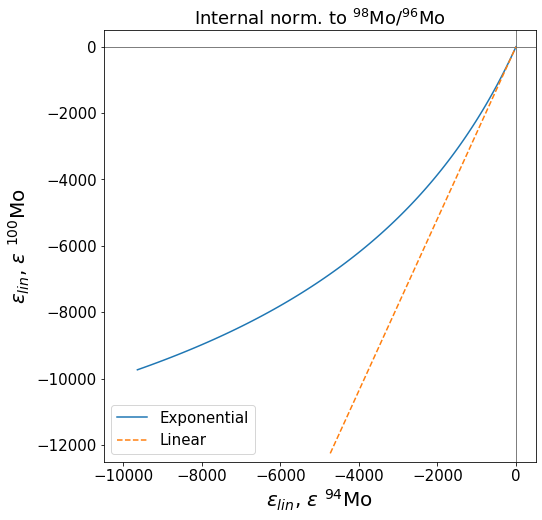

In [7]:
x = np.linspace(0, 1, 100)
sample = (solar_mo * x + SiC_mo*(1-x)).ratio('96mo') 

corrected_sample = (sample/solar_L09)

Q = np.log(mass_mo)/ np.log(mass_mo.get(normrat))
exponential = (corrected_sample * np.power(corrected_sample.get(normrat), -Q) -1) * 1E4
linear = ((corrected_sample-1) - Q * (corrected_sample.get(normrat)-1)) * 1E4


isopy.tb.update_figure(plt, size=(7.5,7.05))
isopy.tb.update_axes(plt, xlabel=r'$\epsilon_{lin}$, $\epsilon$ $^{94}\rm{Mo}$', 
                          ylabel=r'$\epsilon_{lin}$, $\epsilon$ $^{100}\rm{Mo}$',
                          title='Internal norm. to $^{98}$Mo/$^{96}$Mo',
                          ylim = (-12500, 500), 
                          xlim = (-10500, 500))
plt.axhline(0, color='black', linestyle='-', linewidth = 0.5)
plt.axvline(0, color='black', linestyle='-', linewidth = 0.5)

isopy.tb.plot_scatter(plt, exponential['mo100/96mo'], exponential['mo94/96mo'], 
                      marker=False, line='-', label='Exponential')
isopy.tb.plot_scatter(plt, linear['mo100/96mo'], linear['mo94/96mo'], 
                      marker=False, line='--', label='Linear')

plt.legend()
plt.subplots_adjust(left=0.18, bottom=0.1, right=0.98, top=0.95)
#plt.savefig('Output/Figure3-Exp_vs_Lin.pdf')

---
## Figure 4

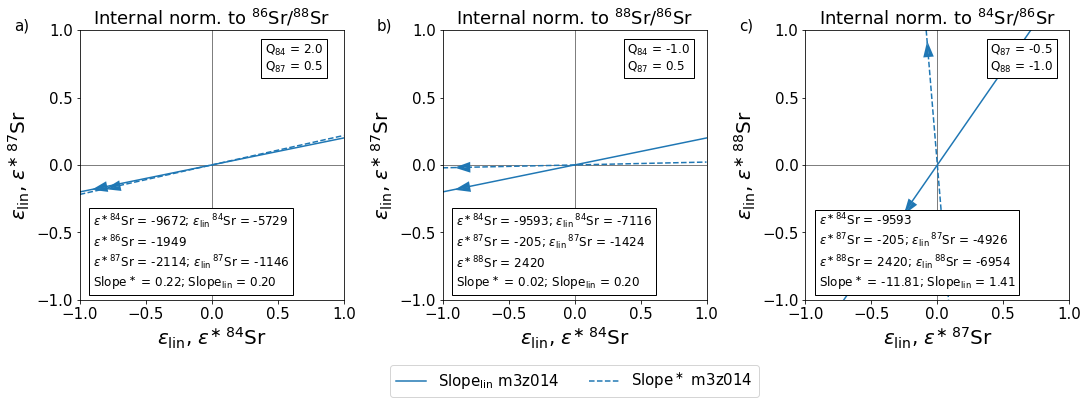

In [8]:
fig3_models = select_models(monash_models, name_eq = 'm3z014')

sr68_in = internal_normalisation(fig3_models, '86sr/88sr', solar_L09)
sr86_in = internal_normalisation(fig3_models, '88sr/86sr', solar_L09)
sr46_in = internal_normalisation(fig3_models, '84sr/86sr', solar_L09)

sr68_n = simple_normalisation(fig3_models, '88sr', solar_L09)
sr86_n = simple_normalisation(fig3_models, '86sr', solar_L09)
sr46_n = simple_normalisation(fig3_models, '86sr', solar_L09)

axes = create_subplots(3, (1,3), legend=True, legend_ratio = 0.1)

plot_slope(axes.ax0, '84sr', '87sr', sr68_in, sr68_n, title='Internal norm. to $^{86}$Sr/$^{88}$Sr', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.9],[0.8]])
plot_slope(axes.ax1, '84sr', '87sr', sr86_in, sr86_n, title='Internal norm. to $^{88}$Sr/$^{86}$Sr', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.9],[0.9]])
plot_slope(axes.ax2, '87sr', '88sr', sr46_in, sr46_n, title='Internal norm. to $^{84}$Sr/$^{86}$Sr', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.35],[0.9]])

# Panel 1 text
axes.ax0.annotate(f"${EPS_star}\,^{{84}}$Sr = {sr68_n['84Sr']:.0f}; ${EPS_lin}\,^{{84}}$Sr = {sr68_in['84Sr']:.0f}\n"
                  f"${EPS_star}\,^{{86}}$Sr = {sr68_n['86Sr']:.0f}\n"
                  f"${EPS_star}\,^{{87}}$Sr = {sr68_n['87Sr']:.0f}; ${EPS_lin}\,^{{87}}$Sr = {sr68_in['87Sr']:.0f}\n"
                  f"Slope$^\\ast$ = {sr68_n['87Sr']/sr68_n['84Sr']:.2f}; Slope${lin}$ = {sr68_in['87Sr']/sr68_in['84Sr']:.2f}"
                   , (0.05, 0.05), xycoords='axes fraction', fontsize=12, 
                     bbox = dict(boxstyle='square', facecolor='white'))

axes.ax0.annotate(f"Q$_{{{'84'}}}$ = {(np.log(mass['84Sr'])-np.log(mass['88Sr']))/(np.log(mass['86Sr'])-np.log(mass['88Sr'])):.1f}\n"
                  f"Q$_{{{'87'}}}$ = {(np.log(mass['87Sr'])-np.log(mass['88Sr']))/(np.log(mass['86Sr'])-np.log(mass['88Sr'])):.1f}" 
                  , (0.7, 0.85), xycoords='axes fraction', fontsize=12, 
                     bbox = dict(boxstyle='square', facecolor='white'))


# Panel 2 text
axes.ax1.annotate(f"${EPS_star}\,^{{84}}$Sr = {sr86_n['84Sr']:.0f}; ${EPS_lin}\,^{{84}}$Sr = {sr86_in['84Sr']:.0f}\n"
                  f"${EPS_star}\,^{{87}}$Sr = {sr86_n['87Sr']:.0f}; ${EPS_lin}\,^{{87}}$Sr = {sr86_in['87Sr']:.0f}\n"
                  f"${EPS_star}\,^{{88}}$Sr = {sr86_n['88Sr']:.0f}\n"
                  f"Slope$^\\ast$ = {sr86_n['87Sr']/sr86_n['84Sr']:.2f}; Slope${lin}$ = {sr86_in['87Sr']/sr86_in['84Sr']:.2f}"
                   , (0.05, 0.05), xycoords='axes fraction', fontsize=12, 
                     bbox = dict(boxstyle='square', facecolor='white'))

axes.ax1.annotate(f"Q$_{{{'84'}}}$ = {(np.log(mass['84Sr'])-np.log(mass['86Sr']))/(np.log(mass['88Sr'])-np.log(mass['86Sr'])):.1f}\n"
                  f"Q$_{{{'87'}}}$ = {(np.log(mass['87Sr'])-np.log(mass['86Sr']))/(np.log(mass['88Sr'])-np.log(mass['86Sr'])):.1f}" 
                  , (0.7, 0.85), xycoords='axes fraction', fontsize=12, 
                     bbox = dict(boxstyle='square', facecolor='white'))


# Panel 3 text
axes.ax2.annotate(f"${EPS_star}\,^{{84}}$Sr = {sr46_n['84Sr']:.0f}\n"
                  f"${EPS_star}\,^{{87}}$Sr = {sr46_n['87Sr']:.0f}; ${EPS_lin}\,^{{87}}$Sr = {sr46_in['87Sr']:.0f}\n"
                  f"${EPS_star}\,^{{88}}$Sr = {sr46_n['88Sr']:.0f}; ${EPS_lin}\,^{{88}}$Sr = {sr46_in['88Sr']:.0f}\n"
                  f"Slope$^\\ast$ = {sr46_n['88Sr']/sr46_n['87Sr']:.2f}; Slope${lin}$ = {sr46_in['88Sr']/sr46_in['87Sr']:.2f}"
                   , (0.05, 0.05), xycoords='axes fraction', fontsize=12, 
                     bbox = dict(boxstyle='square', facecolor='white'))

axes.ax2.annotate(f"Q$_{{{'87'}}}$ = {(np.log(mass['87Sr'])-np.log(mass['86Sr']))/(np.log(mass['84Sr'])-np.log(mass['86Sr'])):.1f}\n"
                  f"Q$_{{{'88'}}}$ = {(np.log(mass['88Sr'])-np.log(mass['86Sr']))/(np.log(mass['84Sr'])-np.log(mass['86Sr'])):.1f}" 
                  , (0.7, 0.85), xycoords='axes fraction', fontsize=12, 
                     bbox = dict(boxstyle='square', facecolor='white'))

create_legend(axes.legend, fig3_models['name'], 'Slope$_{\\rm{lin}}$', r'Slope$^\ast$', ncol=3)

#plt.savefig('Output/Figure4-Sr.pdf')

---
## Figure 5

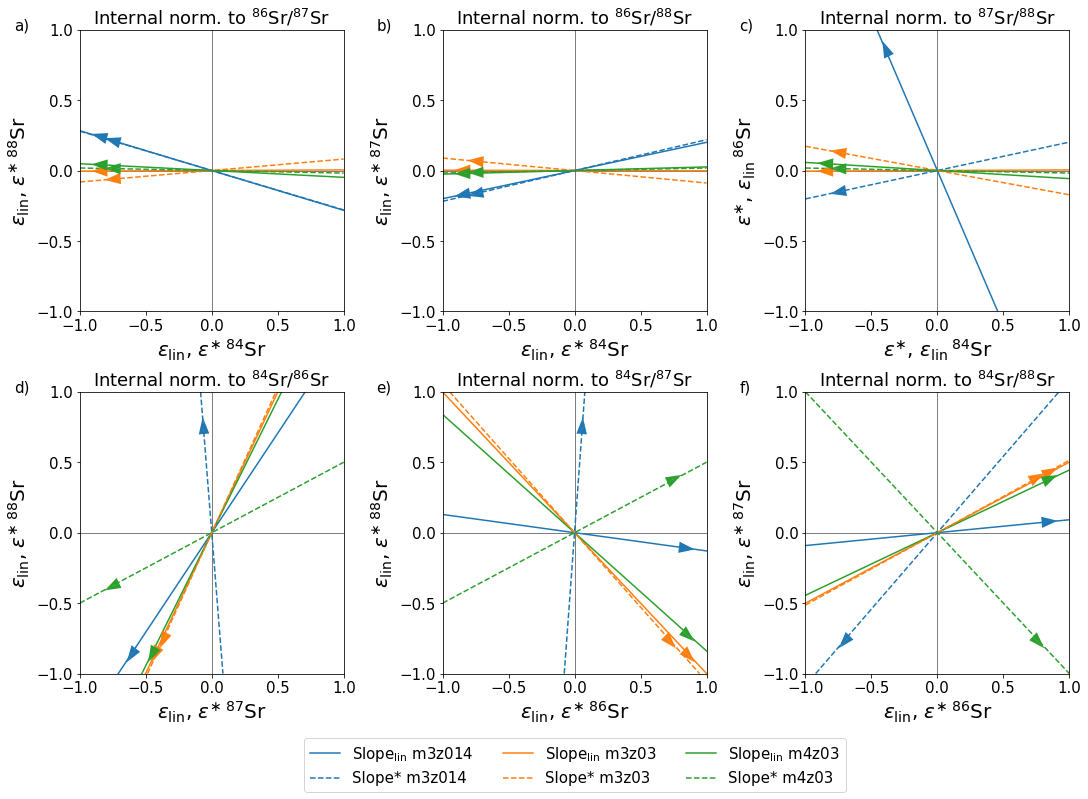

In [9]:
fig4_models = select_models(monash_models)

sr67_in = internal_normalisation(fig4_models, '86sr/87sr', solar_L09)
sr68_in = internal_normalisation(fig4_models, '86sr/88sr', solar_L09)
sr78_in = internal_normalisation(fig4_models, '87sr/88sr', solar_L09)
sr46_in = internal_normalisation(fig4_models, '84sr/86sr', solar_L09)
sr47_in = internal_normalisation(fig4_models, '84sr/87sr', solar_L09)
sr48_in = internal_normalisation(fig4_models, '84sr/88sr', solar_L09)

sr67_n = simple_normalisation(fig4_models, '87sr', solar_L09)
sr68_n = simple_normalisation(fig4_models, '88sr', solar_L09)
sr78_n = simple_normalisation(fig4_models, '88sr', solar_L09)
sr46_n = simple_normalisation(fig4_models, '86sr', solar_L09)
sr47_n = simple_normalisation(fig4_models, '87sr', solar_L09)
sr48_n = simple_normalisation(fig4_models, '88sr', solar_L09)

axes = create_subplots(6, (-1,3), legend=True, legend_ratio = 0.2)

plot_slope(axes.ax0, '84sr', '88sr', sr67_in, sr67_n, title='Internal norm. to $^{86}$Sr/$^{87}$Sr', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.9, 0.9, 0.9],[0.8, 0.8, 0.8]])
plot_slope(axes.ax1, '84sr', '87sr', sr68_in, sr68_n, title='Internal norm. to $^{86}$Sr/$^{88}$Sr', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.9, 0.9, 0.9],[0.8, 0.8, 0.8]])
plot_slope(axes.ax2, '84sr', '86sr', sr78_in, sr78_n, title='Internal norm. to $^{87}$Sr/$^{88}$Sr', 
           epsilon=(EPS_star, EPS_lin), arrow=True, arrow_position=[[0.9, 0.9, 0.9],[0.8, 0.8, 0.8]])


plot_slope(axes.ax3, '87sr', '88sr', sr46_in, sr46_n, title='Internal norm. to $^{84}$Sr/$^{86}$Sr', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.9, 0.9, 0.9],[0.8, 0.8, 0.8]])
plot_slope(axes.ax4, '86sr', '88sr', sr47_in, sr47_n, title='Internal norm. to $^{84}$Sr/$^{87}$Sr', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.9, 0.9, 0.9],[0.8, 0.8, 0.8]])
plot_slope(axes.ax5, '86sr', '87sr', sr48_in, sr48_n, title='Internal norm. to $^{84}$Sr/$^{88}$Sr', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.9, 0.9, 0.9],[0.8, 0.8, 0.8]])

create_legend(axes.legend, fig4_models['name'], 'Slope$_{\\rm{lin}}$', 'Slope*', ncol=3)

#plt.savefig('Output/Figure5-Sr.pdf')

---
## Figure 6

Text(0.05, 0.9, 'N($^{95}$Mo)/1.3')

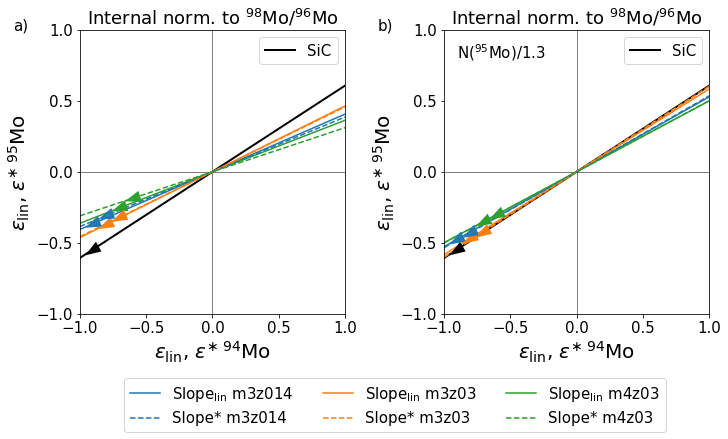

In [10]:
fig5_models1 = select_models(monash_models)

fig5_models2 = select_models(monash_models)
fig5_models2['abundance']['95mo'] = fig5_models2['abundance']['95mo'] / 1.3

mo86_in = internal_normalisation(fig5_models1, '98mo/96mo', solar_L09)
mo86_in2 = internal_normalisation(fig5_models2, '98mo/96mo', solar_L09)

mo86_n = simple_normalisation(fig5_models1, '96mo', solar_L09)
mo86_n2 = simple_normalisation(fig5_models2, '96mo', solar_L09)

axes = create_subplots(2, (1,2), legend=True, legend_ratio = 0.2)

isopy.tb.plot_regression(axes.ax0, (0.608, 0), color='black', label='SiC', linewidth=2, label_equation=False)
plot_arrow(axes.ax0, -1, -0.608, 0.95, 'black')
isopy.tb.plot_regression(axes.ax1, (0.608, 0), color='black', label='SiC', linewidth=2, label_equation=False)
plot_arrow(axes.ax1, -1, -0.608, 0.95, 'black')

axes.ax0.legend()
axes.ax1.legend()

plot_slope(axes.ax0, '94mo', '95mo', mo86_in, mo86_n, title='Internal norm. to $^{98}$Mo/$^{96}$Mo', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.95, 0.85, 0.75],[0.85, 0.75, 0.65]])
plot_slope(axes.ax1, '94mo', '95mo', mo86_in2, mo86_n2, title='Internal norm. to $^{98}$Mo/$^{96}$Mo', 
           epsilon=(EPS_lin, EPS_star), arrow=True, arrow_position=[[0.95, 0.85, 0.75],[0.85, 0.75, 0.65]])

create_legend(axes.legend, fig5_models1['name'], 'Slope$_{\\rm{lin}}$', 'Slope*', ncol=3)

axes.ax1.annotate('N($^{95}$Mo)/1.3', (0.05, 0.9), xycoords='axes fraction')

#plt.savefig('Output/Figure6-Mo.pdf')

# Normalisation Comparison
---

The code below generated the data set used to compare the exponential, linear, and the Dauphas linear equations for creating mixing lines for a given internal normalisation ratio. To generate values for a different internal normalisation ratio change the value of the *norm_rat* variable. 

In [11]:
normrat_values

(row),$\cfrac{{}^{57}\mathrm{Fe}}{{}^{54}\mathrm{Fe}}$ (f8),$\cfrac{{}^{57}\mathrm{Fe}}{{}^{56}\mathrm{Fe}}$ (f8),$\cfrac{{}^{61}\mathrm{Ni}}{{}^{58}\mathrm{Ni}}$ (f8),$\cfrac{{}^{62}\mathrm{Ni}}{{}^{58}\mathrm{Ni}}$ (f8),$\cfrac{{}^{67}\mathrm{Zn}}{{}^{64}\mathrm{Zn}}$ (f8),$\cfrac{{}^{68}\mathrm{Zn}}{{}^{64}\mathrm{Zn}}$ (f8),$\cfrac{{}^{86}\mathrm{Sr}}{{}^{88}\mathrm{Sr}}$ (f8),$\cfrac{{}^{94}\mathrm{Zr}}{{}^{90}\mathrm{Zr}}$ (f8),$\cfrac{{}^{98}\mathrm{Mo}}{{}^{96}\mathrm{Mo}}$ (f8),$\cfrac{{}^{99}\mathrm{Ru}}{{}^{101}\mathrm{Ru}}$ (f8),$\cfrac{{}^{108}\mathrm{Pd}}{{}^{105}\mathrm{Pd}}$ (f8),$\cfrac{{}^{134}\mathrm{Ba}}{{}^{136}\mathrm{Ba}}$ (f8),$\cfrac{{}^{134}\mathrm{Ba}}{{}^{138}\mathrm{Ba}}$ (f8),$\cfrac{{}^{146}\mathrm{Nd}}{{}^{144}\mathrm{Nd}}$ (f8),$\cfrac{{}^{147}\mathrm{Sm}}{{}^{154}\mathrm{Sm}}$ (f8),$\cfrac{{}^{147}\mathrm{Sm}}{{}^{152}\mathrm{Sm}}$ (f8),$\cfrac{{}^{166}\mathrm{Er}}{{}^{168}\mathrm{Er}}$ (f8),$\cfrac{{}^{174}\mathrm{Yb}}{{}^{172}\mathrm{Yb}}$ (f8),$\cfrac{{}^{179}\mathrm{Hf}}{{}^{177}\mathrm{Hf}}$ (f8),$\cfrac{{}^{186}\mathrm{W}}{{}^{183}\mathrm{W}}$ (f8),$\cfrac{{}^{186}\mathrm{W}}{{}^{184}\mathrm{W}}$ (f8)
0,0.36255,0.02310,0.01674,0.05339,0.08216,0.38556,0.11940,0.33810,1.45317,0.74508,1.18899,0.30780,0.03371,0.72190,0.65918,0.56083,1.24140,1.47720,0.73250,1.98590,0.92767


In [12]:
comparison_models = select_models(fruity_models, m_in=[3, 4])
norm_ratio = '98Mo/96Mo' # Change for different element/normalisation ratio

norm_ratio = isopy.askeystring(norm_ratio, flavour='ratio[isotope, isotope]')
norm_value = normrat_values[norm_ratio]

# Renormalise the solar values so that the value of the internal normalisation ratio
# is the same as the one from Table 2
solar_L09_renorm = recalculate_solar(solar_L09, norm_ratio,  norm_value)
solar_AG89_renorm = recalculate_solar(solar_AG89, norm_ratio,  norm_value)

# This section calculated the offsets for a synthethic sample where the
# largest offset in an isotope is always 1 (or -1).

# Calculate the offsets using the solar values from Lodders et al. 2009
exponential_L09 = internal_normalisation(comparison_models, norm_ratio, solar_L09, linear=False, largest_offset=1)
linear_L09 = internal_normalisation(comparison_models, norm_ratio, solar_L09, linear=True, largest_offset=1)
linear_L09r = internal_normalisation(comparison_models, norm_ratio, solar_L09_renorm, linear=True, largest_offset=1)
dauphas_L09 = dauphas_normalisation(comparison_models, norm_ratio, solar_L09, largest_offset=1)

# Calculated the offsets using the solar values from Anders & Grevesse 1989
exponential_AG89 = internal_normalisation(comparison_models, norm_ratio, solar_AG89, linear=False, largest_offset=1)
linear_AG89 = internal_normalisation(comparison_models, norm_ratio, solar_AG89, linear=True, largest_offset=1)
linear_AG89r = internal_normalisation(comparison_models, norm_ratio, solar_AG89_renorm, linear=True, largest_offset=1)
dauphas_AG89 = dauphas_normalisation(comparison_models, norm_ratio, solar_AG89, largest_offset=1)

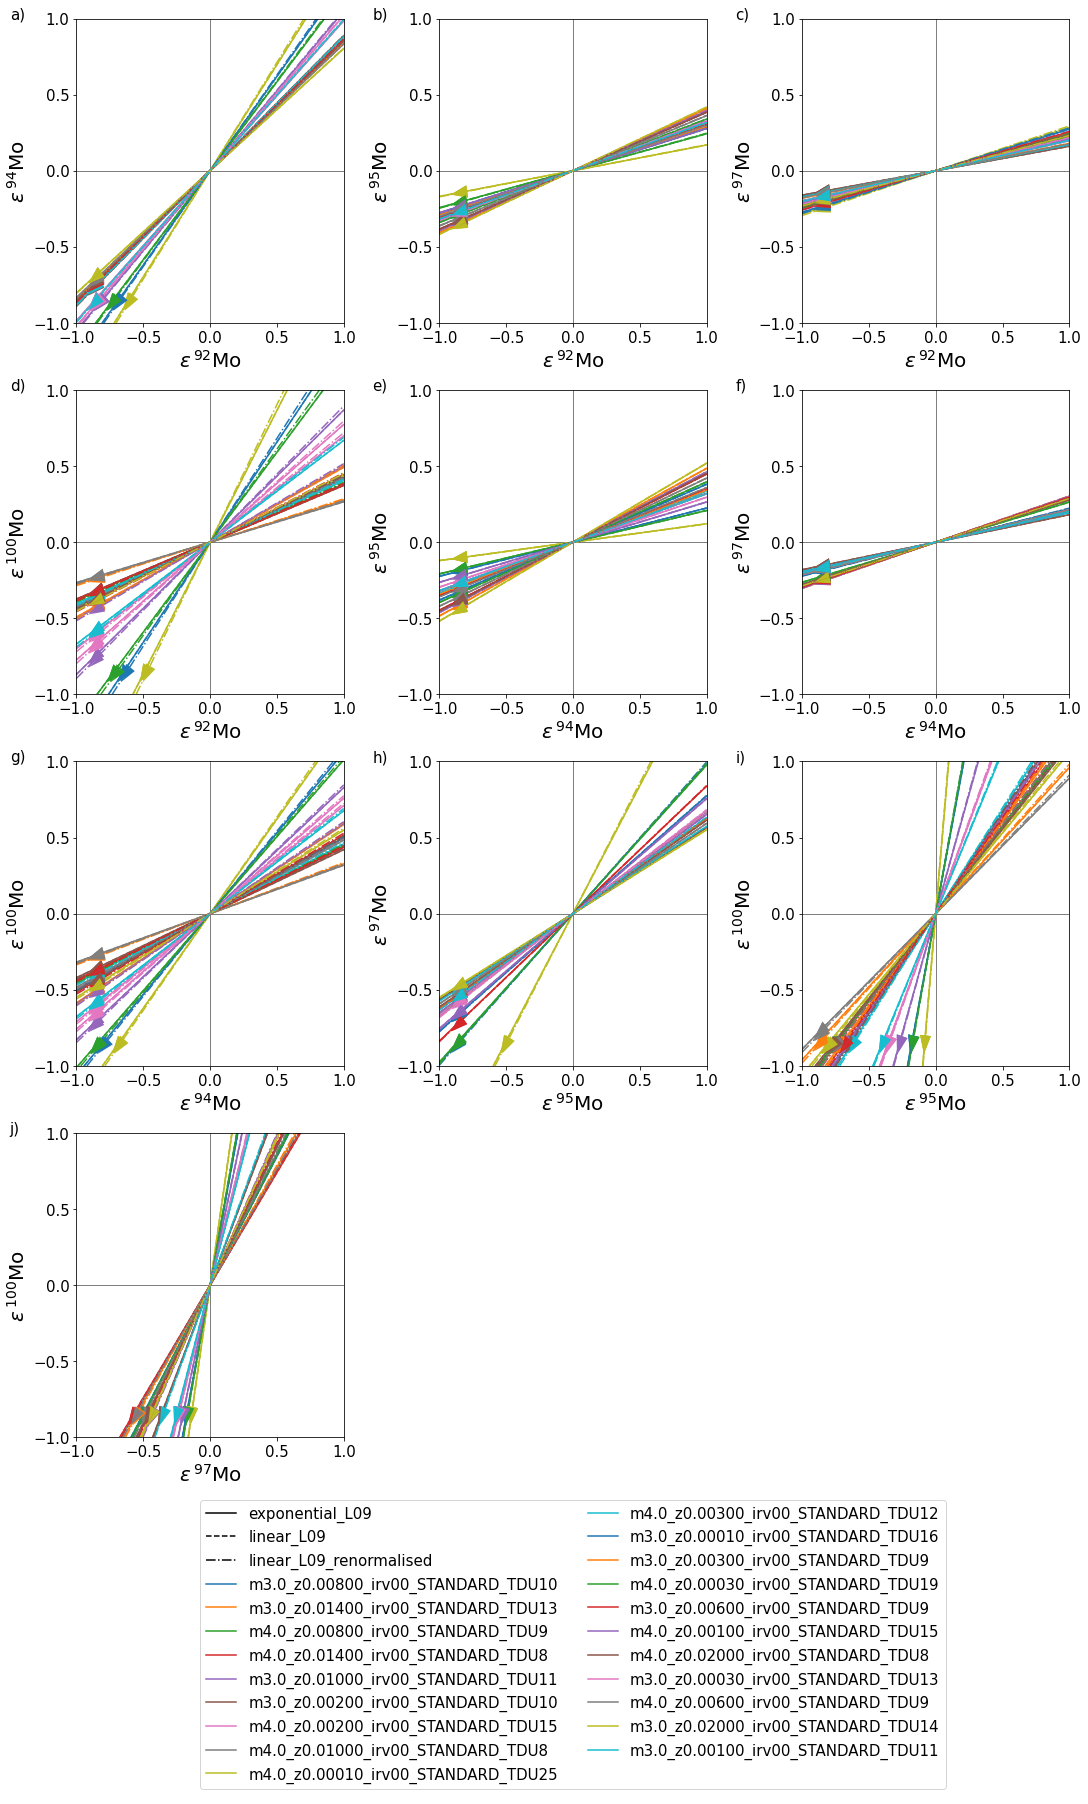

In [13]:
# To omitt a dataset put a # sign before it in the code below
plot_all(comparison_models['name'], 
         exponential_L09=exponential_L09,
         linear_L09=linear_L09,
         linear_L09_renormalised = linear_L09r,
         #dauphas_L09 = dauphas_L09, 
         simplified_legend=True, arrow=True)

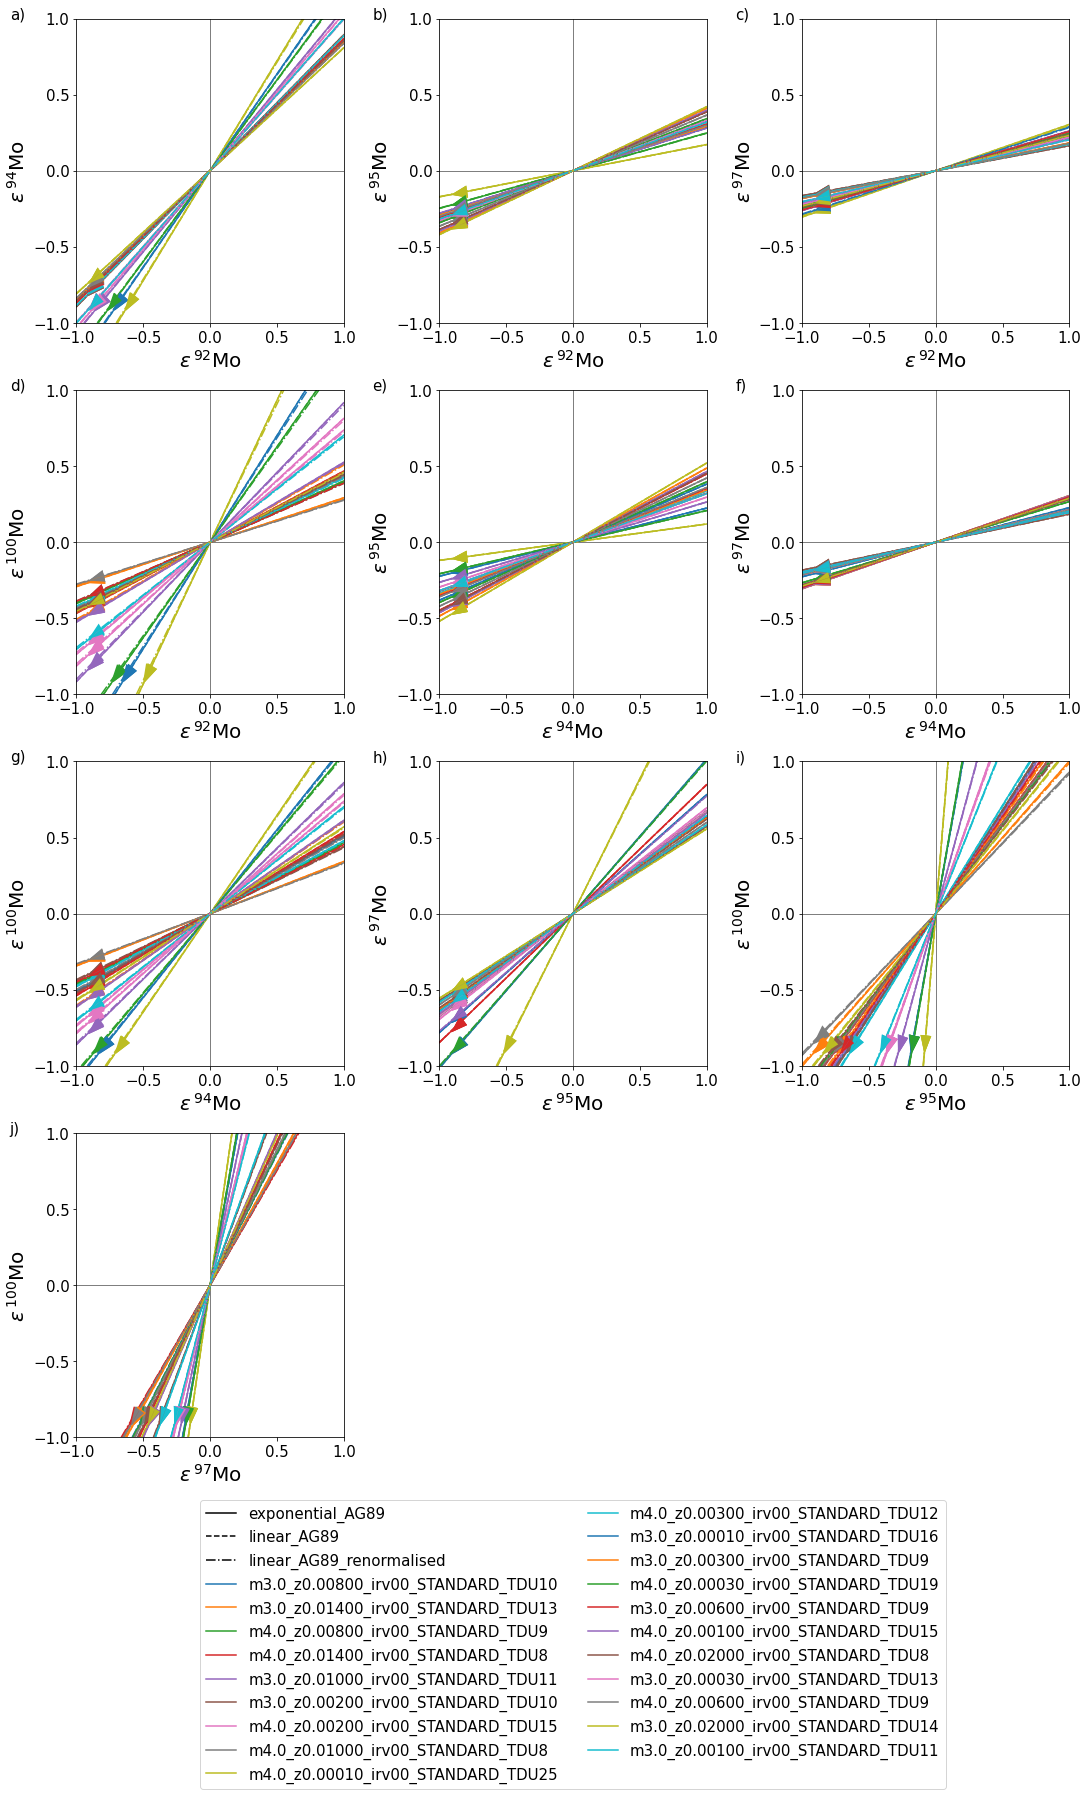

In [14]:
# To omitt a dataset put a # sign before it in the code below
plot_all(comparison_models['name'],
         exponential_AG89=exponential_AG89,
         linear_AG89=linear_AG89,
         linear_AG89_renormalised = linear_AG89r,
         #dauphas_AG89 = dauphas_AG89,
         simplified_legend=True, arrow=True)

---
The following creates an excel file comparing the different internal normalisation methods and solar values for each normalisation ratio listed in Table 1. The excel file generated by the code below is available [here](https://github.com/mattias-ek/internal_normalisation/raw/main/NormalisationComparison.xlsx).

Each sheet contains the values from the exponential, linear and dauphas internal normalisations for Lodders et al. [3] and Anders & Grevesse [4] solar values, as is and renormalised to the values listed in Table 1 of Lugaro et al. [1]. Also included is each set of values divided by the *Exponential L09* data set values and a figure of the different regressions for each solar value.

In [15]:
def create_summary(filename, normalisation_ratios, include_figures = True):
    models = select_models(fruity_models, m_in=[3, 4])
    
    # Creates a progress bar so we can see the progress
    normalisation_ratios = isopy.asarray(normalisation_ratios)

    # Create a in-memory file
    file = openpyxl.load_workbook('Input/Template_Comparison.xlsx')
    xlsx_kwargs = dict(append=True, clear=False, comment_symbol='')
    xlsx_kwargs_eps = dict(append=True, clear=False, comment_symbol='', keyfmt='ε {key}')

    # Use all the models
    model_names = isopy.array({'Model name': models['name']})
    model_names.to_xlsx(file, sheetname = 'Plot', start_at='A9', **xlsx_kwargs)
    file['Plot'].cell(33, 1).value = 'Exponential L09'
    file['Plot'].cell(34, 1).value = 'Linear L09'
    file['Plot'].cell(35, 1).value = 'Linear L09 renormalised'
    file['Plot'].cell(36, 1).value = 'Dauphas L09'
    file['Plot'].cell(37, 1).value = 'Exponential AG89'
    file['Plot'].cell(38, 1).value = 'Linear AG89'
    file['Plot'].cell(39, 1).value = 'Linear AG89 renormalised'
    file['Plot'].cell(40, 1).value = 'Dauphas AG89'
    
    row1 = 1
    row2 = row1 + model_names.nrows + 3 + 1
    row3 = row2 + model_names.nrows + 3 + 1
    sheet = 0
    
    # Loop through all the internal normalisations given in Table 1
    for i, (norm_ratio, norm_value) in enumerate(normalisation_ratios.items()):
        norm_ratio = isopy.askeystring(norm_ratio, flavour='ratio[isotope, isotope]')
        norm_value = np.float64(norm_value)
        
        print(f'Working on {norm_ratio} ({i+1}/{len(normalisation_ratios.keys)})')
        
        solar_L09_renorm = recalculate_solar(solar_L09, norm_ratio,  norm_value)
        solar_AG89_renorm = recalculate_solar(solar_AG89, norm_ratio,  norm_value)

        exponential_L09 = internal_normalisation(models, norm_ratio, solar_L09, linear=False, largest_offset=1)
        linear_L09 = internal_normalisation(models, norm_ratio, solar_L09, linear=True, largest_offset=1)
        linear_L09r = internal_normalisation(models, norm_ratio, solar_L09_renorm, linear=True, largest_offset=1)
        dauphas_L09 = dauphas_normalisation(models, norm_ratio, solar_L09, largest_offset=1)

        exponential_AG89 = internal_normalisation(models, norm_ratio, solar_AG89, linear=False, largest_offset=1)
        linear_AG89 = internal_normalisation(models, norm_ratio, solar_AG89, linear=True, largest_offset=1)
        linear_AG89r = internal_normalisation(models, norm_ratio, solar_AG89_renorm, linear=True, largest_offset=1)
        dauphas_AG89 = dauphas_normalisation(models, norm_ratio, solar_AG89, largest_offset=1)

        sheetname = norm_ratio.replace('/', '_')
        file['Plot'].cell(9 + i, 61).value = sheetname
        for j, iso in enumerate(exponential_L09.keys):
            file['Plot'].cell(9 + i, 62+j).value = iso
        
        col = 1

        # model names
        model_names.to_xlsx(file, sheetname = sheetname, start_at=(row1+2, col), **xlsx_kwargs)

        model_names.to_xlsx(file, sheetname = sheetname, start_at=(row2+1, col), **xlsx_kwargs)

        col += model_names.ncols + 1

        ##########################
        ### Lodders et al 2009 ###
        ##########################

        # exponential equation
        data = exponential_L09
        comment = ['Exponential L09', f'Int. norm. {norm_ratio} = {solar_L09.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs_eps)

        col += data.ncols + 1

        # linear equation
        data = linear_L09
        comment = ['Linear L09', f'Int. norm. {norm_ratio} = {solar_L09.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs_eps)

        data = linear_L09 / exponential_L09
        comment = 'Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # Linear renormalised solar
        data = linear_L09r
        comment = ['Linear L09 renormalised', f'Int. norm. {norm_ratio} = {solar_L09_renorm.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs_eps)

        data = linear_L09r / exponential_L09
        comment = 'Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # Dauphas
        data = dauphas_L09
        comment = ['Dauphas L09', f'Int. norm. {norm_ratio} = {solar_L09.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs_eps)

        data = dauphas_L09 / exponential_L09
        comment = 'Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1
        
        if include_figures:
            plt.clf() # Clear current plot
            try:
                fig = plot_all(models['name'], 
                               exponential_L09=exponential_L09,
                               linear_L09=linear_L09,
                               linear_L09_renormalised = linear_L09r,
                               dauphas_L09 = dauphas_L09,
                               simplified_legend=True, arrow=True)
            except:
                print(f'Error creating figure for {norm_ratio} L09')
            else:
                image = io.BytesIO()
                plt.savefig(image, transparent=False, facecolor='white')

                img = openpyxl.drawing.image.Image(image)
                img.anchor = f'A{row3}'
                file[sheetname].add_image(img)

        ##############################
        ### Anders & Grevasse 1989 ###
        ##############################

        # exponential equation
        data = exponential_AG89
        comment = ['Exponential AG89', f' {norm_ratio} = {solar_AG89.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs_eps)

        data = exponential_AG89 / exponential_L09
        comment = 'Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # linear equation
        data = linear_AG89
        comment = ['Linear AG89', f' {norm_ratio} = {solar_AG89.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs_eps)

        data = linear_AG89 / exponential_L09
        comment = 'Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # Linear renormalised solar
        data = linear_AG89r
        comment = ['Linear AG89 renormalised', f' {norm_ratio} = {solar_AG89_renorm.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs_eps)

        data = linear_AG89r / exponential_L09
        comment = 'Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1

        # Dauphas
        data = dauphas_AG89
        comment = ['Dauphas AG89', f' {norm_ratio} = {solar_AG89.get(norm_ratio):f}']
        data.to_xlsx(file, sheetname = sheetname, start_at=(row1, col), comments = comment, **xlsx_kwargs_eps)

        data = dauphas_AG89 / exponential_L09
        comment = 'Above/Exponential L09'
        data.to_xlsx(file, sheetname = sheetname, start_at=(row2, col), comments = comment, **xlsx_kwargs)

        col += data.ncols + 1
        
        if include_figures:
            plt.clf() # Clear current plot
            try:
                fig = plot_all(models['name'], 
                               exponential_AG89=exponential_AG89,
                               linear_AG89=linear_AG89,
                               linear_AG89_renormalised = linear_AG89r,
                               dauphas_AG89 = dauphas_AG89,
                               simplified_legend=True, arrow=True)
            except:
                print(f'Error creating figure for {norm_ratio} AG89')
            else:
                image = io.BytesIO()
                plt.savefig(image, transparent=False, facecolor='white')

                img = openpyxl.drawing.image.Image(image)
                img.anchor = f'Q{row3}'
                file[sheetname].add_image(img)
    
    file.save(filename)
    plt.clf()
    print('Finished')

#create_summary('Output/NormalisationComparison.xlsx', normrat_values, include_figures=True);